# Load dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import scipy
from scipy.signal import savgol_filter
from scipy.spatial.distance import pdist,squareform
from scipy.stats import mannwhitneyu
import torch
import torch.nn.functional as F
import math
from matplotlib import pyplot as plt
import umap

from models import SimpleEncoder,Decoder,PriorDiscriminator,LocalDiscriminator
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy

from IPython.display import clear_output
import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')

In [3]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

In [4]:
def uniformLoss(curState, dataIndex, z, targetMin = 0, targetMax = 1.0, maxConstraintFactor = 10):
    data = curState.detach().clone()
    data[dataIndex, :] = z

    targetMean = (targetMax-targetMin)/2
    targetVar= (targetMax-targetMin)**2/12

    factor = 1
    meanFactor = factor
    varFactor = factor
    minFactor = factor
    maxFactor = factor
    maxConstraintFactor = factor * maxConstraintFactor

    nodeMean = torch.mean(data, dim=0)
    nodeVar = torch.mean(torch.square(data-nodeMean), dim=0)
    maxVal, _ = torch.max(data, dim=0)
    minVal, _ = torch.min(data, dim=0)

    meanLoss = meanFactor * torch.sum(torch.square(nodeMean - targetMean))
    varLoss =  varFactor * torch.sum(torch.square(nodeVar - targetVar))
    maxLoss = maxFactor * torch.sum(torch.square(maxVal - targetMax))
    minloss = minFactor * torch.sum(torch.square(minVal- targetMin))
    maxConstraint = -maxConstraintFactor * torch.sum(maxVal[maxVal.detach()<=0]) #max value should never be negative

    loss = meanLoss + varLoss + minloss + maxLoss + maxConstraint
    return loss

In [5]:
def NormalLoss(curState, dataIndex, z, targetMin = -5.01, targetMax = 5.01, maxConstraintFactor = 10):
    data = curState.detach().clone()
    data[dataIndex, :] = z

    targetMean = 0.
    targetVar= 1.

    factor = 1
    meanFactor = factor
    varFactor = factor
    minFactor = factor
    maxFactor = factor
    maxConstraintFactor = factor * maxConstraintFactor

    nodeMean = torch.mean(data, dim=0)
    nodeVar = torch.mean(torch.square(data-nodeMean), dim=0)
    maxVal, _ = torch.max(data, dim=0)
    minVal, _ = torch.min(data, dim=0)

    meanLoss = meanFactor * torch.sum(torch.square(nodeMean - targetMean))
    varLoss =  varFactor * torch.sum(torch.square(nodeVar - targetVar))
    maxLoss = maxFactor * torch.sum(torch.square(maxVal - targetMax))
    minloss = minFactor * torch.sum(torch.square(minVal- targetMin))
    maxConstraint = -maxConstraintFactor * torch.sum(maxVal[maxVal.detach()<=0]) #max value should never be negative

    loss = meanLoss + varLoss + minloss + maxLoss + maxConstraint
    return loss

In [6]:
# def kl_loss(s1,s2,m1,m2):
#     l = torch.log(s2/s1 + 1e-6) + (s1**2 +(m1-m2)**2)/(2*s2**2 + 1e-6) - 0.5
#     return l.mean()
def kl_loss(m,s):
    l = torch.square(m) + torch.square(s) - torch.log(s + 1e-04) - 0.5
    return l.mean()

# Load Data

In [7]:
# Gex data 
cmap = pd.read_csv('../preprocessing/preprocessed_data/all_cmap_landmarks.csv',index_col=0)
gene_size = len(cmap.columns)
X = cmap.values
display(cmap)

,16,23,25,30,39,47,102,128,142,154,...,94239,116832,124583,147179,148022,200081,200734,256364,375346,388650
PCL001_HT29_24H:BRD-K42991516:10,0.266452,-0.250874,-0.854204,-0.041545,0.204450,0.709800,-0.328601,-0.498116,-1.454481,0.506321,...,0.536235,0.024452,0.928558,-0.453246,-0.140290,0.205065,1.148706,-1.933820,1.966937,-0.159919
PCL001_HT29_24H:BRD-K50817946:10,6.074023,-0.524075,-0.635742,2.014629,-3.747274,2.109600,0.847576,-2.732549,-5.729352,2.164091,...,0.447939,1.543649,-3.775020,1.827991,-0.088051,0.382848,1.400255,-3.087269,1.392148,1.027263
HOG002_A549_24H:BRD-K28296557-005-14-6:3.33,3.092555,1.760324,0.045857,-0.267738,-5.237659,-1.254134,-1.197927,-2.120804,-2.096229,0.799317,...,0.253642,-0.461737,-2.344703,1.581582,4.007076,-0.203330,0.715596,1.502107,1.281574,0.450898
DOSBIO001_MCF7_24H:BRD-K77888550:9.5278,-1.680236,1.174203,0.295703,0.555778,0.136969,-1.507160,-0.068983,-0.468983,-1.894113,-0.035792,...,1.204646,-0.688365,-1.042315,2.571737,-0.085614,-3.472259,1.436653,-1.054814,1.873788,1.680525
DOSBIO001_NPC_24H:BRD-K09069264:10.2084,-1.401400,0.308703,1.178614,-2.114849,-0.020324,-0.393869,-2.599080,-0.983008,-0.063675,-0.549799,...,0.349096,0.017305,0.356195,0.638253,0.862676,-0.106953,1.115011,2.205899,-0.306434,1.101611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOSVAL001_MCF7_24H:BRD-K30867024:10,-0.228277,-0.574911,0.545074,1.320753,-0.102422,1.058099,0.366014,-1.520461,-0.004073,-0.637326,...,-0.057771,-0.660938,-1.952505,0.395937,1.790094,1.072335,1.657834,1.445156,2.031223,0.026611
DOSVAL002_A375_24H:BRD-K10749593:20,4.415511,0.608378,1.604217,-0.911175,-2.611416,-1.742975,-2.500287,-2.503129,-3.472708,3.008501,...,0.916562,-1.403280,0.479218,4.528471,1.701896,0.141621,1.953133,-1.480089,1.549125,1.414482
DOSVAL002_MCF7_24H:BRD-K14002526:20,1.311693,1.834785,1.277888,-0.224320,-0.365258,0.209443,0.166746,-2.112468,-0.870127,-0.083894,...,0.894919,-0.707055,0.519019,0.916627,0.710227,0.126153,2.277303,-1.870382,1.021850,1.199542
DOSVAL001_HT29_24H:BRD-K11624501:9.99164,1.540175,-0.196926,-0.094410,-1.951286,-2.848082,-2.478519,-1.257487,-1.247405,-4.006328,-0.362494,...,-0.371798,3.735393,2.011243,1.693114,2.924200,2.535851,1.861230,-3.021530,0.127304,0.980487


In [8]:
# Gex data for controls
cmap_controls = pd.read_csv('../preprocessing/preprocessed_data/baselineCell/cmap_all_baselines_q1.csv',index_col=0)
display(cmap_controls)

,16,23,25,30,39,47,102,128,142,154,...,94239,116832,124583,147179,148022,200081,200734,256364,375346,388650
OFL001_A549_96H:G15,1.854175,1.868439,-0.140405,-0.278911,0.396597,0.334116,0.473704,-0.565553,1.372410,1.181299,...,1.252141,-0.291923,1.193942,0.978987,2.381282,-1.065447,1.174847,-0.885704,0.879203,0.216700
OFL001_MCF7_96H:J10,0.081511,0.651525,-0.205014,0.054704,0.726742,-0.126017,0.200712,0.915557,0.780285,0.007211,...,0.341261,0.405606,-0.054713,0.264261,-0.096964,0.752965,-0.249324,-1.176310,0.282062,-0.212717
ABY001_NCIH1975_XH:CMAP-000:-666:3,0.543459,1.647965,-1.731661,0.319534,1.078192,0.602553,0.323291,0.787790,0.888264,1.532468,...,0.704732,-1.326966,1.433667,-0.037051,1.016276,-0.481035,1.061352,1.616178,1.540468,-0.958139
ZTO.XPR001_THP1_408H:CMAP-000:-666,-0.054865,-0.085794,-0.319447,0.180520,0.124284,-0.117936,-0.267994,0.429114,-0.144781,0.190815,...,-0.114969,0.308555,0.055869,-0.450732,-0.394338,0.029793,0.046924,-0.231632,-0.186150,-0.309360
MOA001_A549_24H:N01,0.401776,1.197786,0.946556,0.794930,0.662958,0.473484,1.335021,0.338371,0.300303,0.690938,...,0.020668,0.171860,0.862337,0.525409,-0.029795,-0.263026,0.271724,0.934595,0.552001,-0.711617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOSVAL001_HT29_24H:CMAP-000:-666,0.038320,-0.426547,0.183131,0.450992,-0.414180,-0.619587,-0.318295,0.066966,-0.618409,0.539847,...,0.085557,0.018541,0.174058,-0.101450,-0.279539,-0.303862,0.019368,1.111968,0.387193,-0.770082
DOSVAL001_HA1E_24H:CMAP-000:-666,0.319681,-0.182241,0.689418,0.542491,-0.124395,0.252069,-0.348502,0.145006,-0.018389,0.190280,...,-0.048443,0.188158,0.422073,0.123565,0.097611,-0.003442,0.924158,-0.212382,0.166562,0.142994
DOSVAL001_A375_24H:CMAP-000:-666,0.091151,-0.007194,0.360459,0.430177,-0.443078,-0.370296,-0.450974,0.616529,0.258591,0.111886,...,-0.571711,0.084373,0.240619,-0.372428,-0.168089,-0.137313,0.157594,0.256362,0.080780,-0.065995
DOSVAL001_HEPG2_24H:CMAP-000:-666,-0.276361,-0.321295,0.412983,0.040179,-0.144093,-0.374313,-0.488024,0.273988,-0.278131,-0.075510,...,-0.440074,0.220422,-0.144075,-0.162023,-0.328652,-0.300582,0.469960,-0.533808,0.158130,-0.492051


# Train one trasnlation model

In [9]:
model_params = {'encoder_1_hiddens':[384,256],
                'encoder_2_hiddens':[384,256],
                'latent_dim': 128,
                'decoder_1_hiddens':[256,384],
                'decoder_2_hiddens':[256,384],
                'dropout_decoder':0.2,
                'dropout_encoder':0.1,
                'encoder_activation':torch.nn.ELU(),
                'decoder_activation':torch.nn.ELU(),
                'V_dropout':0.25,
                'state_class_hidden':[128,64,32],
                'state_class_drop_in':0.5,
                'state_class_drop':0.25,
                'no_states':2,
                'adv_class_hidden':[128,64,32],
                'adv_class_drop_in':0.3,
                'adv_class_drop':0.1,
                'no_adv_class':2,
                'encoding_lr':0.001,
                'adv_lr':0.001,
                'schedule_step_adv':200,
                'gamma_adv':0.5,
                'schedule_step_enc':200,
                'gamma_enc':0.8,
                'batch_size':512,
                'epochs':1000,
                'no_folds':5,
                'v_reg':1e-04,
                'state_class_reg':1e-02,
                'enc_l2_reg':0.01,
                'dec_l2_reg':0.01,
                'lambda_mi_loss':100,
                'effsize_reg': 100,
                'cosine_loss': 10,
                'adv_penalnty':100,
                'reg_adv':1000,
                'reg_classifier': 1000,
                'similarity_reg' : 10,
                'adversary_steps':4,
                'autoencoder_wd': 0.,
                'adversary_wd': 0.}

In [10]:
prior_betas = [1e-04,1e-03,1e-02,1e-01,1e0,1e1,1e2,1e3,1e4] 

In [11]:
bs =  model_params['batch_size']
# k_folds=model_params['no_folds']
NUM_EPOCHS=model_params['epochs']
# kfold=KFold(n_splits=k_folds,shuffle=True)

In [12]:
# cell = "U2OS"
# df_result_all =  pd.read_csv('../results/PriorLossAnalysis/translation_results_testytest_'+cell+'.csv',index_col=0)
# df_result_all

Cell-line : U2OS, prior beta 0.00, Split 1: Epoch=1/1000, pearson_1=0.1391, MSE_1=1.5459, pearson_2=0.1588, MSE_2=1.5676, MI Loss=0.7917, Prior Loss=0.0001, Cosine =0.5382, silimalityLoss =7.4331, loss=1698.2767
Cell-line : U2OS, prior beta 0.00, Split 1: Epoch=251/1000, pearson_1=0.7715, MSE_1=0.5121, pearson_2=0.7576, MSE_2=0.5547, MI Loss=-0.6818, Prior Loss=0.0000, Cosine =0.8727, silimalityLoss =2.8330, loss=498.8873
Cell-line : U2OS, prior beta 0.00, Split 1: Epoch=501/1000, pearson_1=0.7945, MSE_1=0.5755, pearson_2=0.8111, MSE_2=0.5539, MI Loss=-0.6892, Prior Loss=0.0000, Cosine =0.8750, silimalityLoss =2.0743, loss=519.0176
Cell-line : U2OS, prior beta 0.00, Split 1: Epoch=751/1000, pearson_1=0.8131, MSE_1=0.4966, pearson_2=0.8138, MSE_2=0.4974, MI Loss=-0.7055, Prior Loss=0.0000, Cosine =0.8815, silimalityLoss =1.7784, loss=446.3510
Cell-line : U2OS, prior beta 0.00, Split 1: Epoch=1000/1000, pearson_1=0.8343, MSE_1=0.4266, pearson_2=0.8390, MSE_2=0.4247, MI Loss=-0.7188, Prio

Cell-line : U2OS, prior beta 0.00, Split 2: Epoch=501/1000, pearson_1=0.8434, MSE_1=0.3874, pearson_2=0.8447, MSE_2=0.3942, MI Loss=-0.6490, Prior Loss=0.0000, Cosine =0.8951, silimalityLoss =1.5519, loss=342.6423
Cell-line : U2OS, prior beta 0.00, Split 2: Epoch=751/1000, pearson_1=0.8543, MSE_1=0.3830, pearson_2=0.8524, MSE_2=0.3948, MI Loss=-0.6546, Prior Loss=0.0000, Cosine =0.8989, silimalityLoss =1.2334, loss=334.4345
Cell-line : U2OS, prior beta 0.00, Split 2: Epoch=1000/1000, pearson_1=0.8671, MSE_1=0.3783, pearson_2=0.8655, MSE_2=0.3883, MI Loss=-0.6559, Prior Loss=0.0000, Cosine =0.9072, silimalityLoss =1.0347, loss=324.9912
Validation performance for cell U2OS for beta 0.001 for split 2
Pearson correlation 1: 0.8373018503189087
Pearson correlation 2: 0.8380720019340515
Pearson correlation 1 to 2: 0.8074708580970764
Pearson correlation 2 to 1: 0.8093180656433105
Cell-line : U2OS, prior beta 0.00, Split 3: Epoch=1/1000, pearson_1=0.1110, MSE_1=1.7846, pearson_2=0.1300, MSE_2=1

Cell-line : U2OS, prior beta 0.01, Split 3: Epoch=1000/1000, pearson_1=0.7944, MSE_1=0.5210, pearson_2=0.7998, MSE_2=0.5349, MI Loss=-0.7187, Prior Loss=0.0000, Cosine =0.8840, silimalityLoss =1.5329, loss=471.8695
Validation performance for cell U2OS for beta 0.01 for split 3
Pearson correlation 1: 0.8270685076713562
Pearson correlation 2: 0.8298393487930298
Pearson correlation 1 to 2: 0.799402117729187
Pearson correlation 2 to 1: 0.799019455909729
Cell-line : U2OS, prior beta 0.01, Split 4: Epoch=1/1000, pearson_1=0.1393, MSE_1=1.9332, pearson_2=0.1505, MSE_2=2.0733, MI Loss=0.7812, Prior Loss=0.0122, Cosine =0.5235, silimalityLoss =7.5560, loss=2135.3818
Cell-line : U2OS, prior beta 0.01, Split 4: Epoch=251/1000, pearson_1=0.8115, MSE_1=0.8172, pearson_2=0.8142, MSE_2=0.7406, MI Loss=-0.7719, Prior Loss=0.0000, Cosine =0.8876, silimalityLoss =2.8595, loss=731.1960
Cell-line : U2OS, prior beta 0.01, Split 4: Epoch=501/1000, pearson_1=0.8178, MSE_1=0.5858, pearson_2=0.8051, MSE_2=0.64

Cell-line : U2OS, prior beta 0.10, Split 5: Epoch=1/1000, pearson_1=0.1570, MSE_1=1.7957, pearson_2=0.1513, MSE_2=1.8479, MI Loss=0.9280, Prior Loss=0.1165, Cosine =0.5298, silimalityLoss =7.4385, loss=1971.4335
Cell-line : U2OS, prior beta 0.10, Split 5: Epoch=251/1000, pearson_1=0.7790, MSE_1=0.5210, pearson_2=0.7805, MSE_2=0.5258, MI Loss=-0.7105, Prior Loss=0.0000, Cosine =0.8827, silimalityLoss =2.8088, loss=486.3182
Cell-line : U2OS, prior beta 0.10, Split 5: Epoch=501/1000, pearson_1=0.8386, MSE_1=0.6209, pearson_2=0.8346, MSE_2=0.6048, MI Loss=-0.7018, Prior Loss=0.0000, Cosine =0.8813, silimalityLoss =1.9504, loss=563.8913
Cell-line : U2OS, prior beta 0.10, Split 5: Epoch=751/1000, pearson_1=0.8275, MSE_1=0.4745, pearson_2=0.8240, MSE_2=0.4919, MI Loss=-0.6834, Prior Loss=0.0000, Cosine =0.8838, silimalityLoss =1.6956, loss=434.6000
Cell-line : U2OS, prior beta 0.10, Split 5: Epoch=1000/1000, pearson_1=0.8072, MSE_1=0.5326, pearson_2=0.8068, MSE_2=0.5632, MI Loss=-0.7123, Prio

<ipython-input-13-dce15272c5b4>:190: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Cell-line : U2OS, prior beta 1.00, Split 2: Epoch=1/1000, pearson_1=0.0873, MSE_1=1.9532, pearson_2=0.1022, MSE_2=1.9135, MI Loss=1.5245, Prior Loss=1.2399, Cosine =0.5295, silimalityLoss =7.2662, loss=2139.6196
Cell-line : U2OS, prior beta 1.00, Split 2: Epoch=251/1000, pearson_1=0.8300, MSE_1=0.4275, pearson_2=0.8308, MSE_2=0.4308, MI Loss=-0.6321, Prior Loss=0.0001, Cosine =0.8841, silimalityLoss =2.3099, loss=393.6135
Cell-line : U2OS, prior beta 1.00, Split 2: Epoch=501/1000, pearson_1=0.8454, MSE_1=0.4022, pearson_2=0.8481, MSE_2=0.4044, MI Loss=-0.6492, Prior Loss=0.0000, Cosine =0.8915, silimalityLoss =1.5721, loss=355.2899
Cell-line : U2OS, prior beta 1.00, Split 2: Epoch=751/1000, pearson_1=0.8587, MSE_1=0.3752, pearson_2=0.8592, MSE_2=0.3759, MI Loss=-0.6541, Prior Loss=0.0000, Cosine =0.9019, silimalityLoss =1.2288, loss=321.4842
Cell-line : U2OS, prior beta 1.00, Split 2: Epoch=1000/1000, pearson_1=0.8716, MSE_1=0.3805, pearson_2=0.8675, MSE_2=0.3976, MI Loss=-0.6556, Prio

Cell-line : U2OS, prior beta 10.00, Split 3: Epoch=501/1000, pearson_1=0.7999, MSE_1=0.5004, pearson_2=0.8002, MSE_2=0.5121, MI Loss=-0.6994, Prior Loss=0.0000, Cosine =0.8959, silimalityLoss =2.0376, loss=460.8100
Cell-line : U2OS, prior beta 10.00, Split 3: Epoch=751/1000, pearson_1=0.7789, MSE_1=0.5503, pearson_2=0.7902, MSE_2=0.5129, MI Loss=-0.7279, Prior Loss=0.0000, Cosine =0.8839, silimalityLoss =1.7559, loss=478.2654
Cell-line : U2OS, prior beta 10.00, Split 3: Epoch=1000/1000, pearson_1=0.8009, MSE_1=0.4996, pearson_2=0.8028, MSE_2=0.4885, MI Loss=-0.7381, Prior Loss=0.0000, Cosine =0.8894, silimalityLoss =1.5579, loss=436.9931
Validation performance for cell U2OS for beta 10.0 for split 3
Pearson correlation 1: 0.8263360857963562
Pearson correlation 2: 0.8287758827209473
Pearson correlation 1 to 2: 0.7988277673721313
Pearson correlation 2 to 1: 0.798458456993103
Cell-line : U2OS, prior beta 10.00, Split 4: Epoch=1/1000, pearson_1=0.1580, MSE_1=2.8529, pearson_2=0.1231, MSE_2

Cell-line : U2OS, prior beta 100.00, Split 4: Epoch=1000/1000, pearson_1=0.8087, MSE_1=0.6451, pearson_2=0.8104, MSE_2=0.7594, MI Loss=-0.7530, Prior Loss=0.0016, Cosine =0.8854, silimalityLoss =1.6533, loss=642.1171
Validation performance for cell U2OS for beta 100.0 for split 4
Pearson correlation 1: 0.8262038230895996
Pearson correlation 2: 0.820171058177948
Pearson correlation 1 to 2: 0.7916398048400879
Pearson correlation 2 to 1: 0.7981286644935608
Cell-line : U2OS, prior beta 100.00, Split 5: Epoch=1/1000, pearson_1=0.1184, MSE_1=1.7639, pearson_2=0.1153, MSE_2=1.8142, MI Loss=0.6878, Prior Loss=119.3312, Cosine =0.5312, silimalityLoss =7.3979, loss=2034.1907
Cell-line : U2OS, prior beta 100.00, Split 5: Epoch=251/1000, pearson_1=0.7890, MSE_1=0.6038, pearson_2=0.8028, MSE_2=0.6113, MI Loss=-0.7076, Prior Loss=0.0054, Cosine =0.8886, silimalityLoss =2.6567, loss=567.2975
Cell-line : U2OS, prior beta 100.00, Split 5: Epoch=501/1000, pearson_1=0.8270, MSE_1=0.4871, pearson_2=0.8131

Cell-line : U2OS, prior beta 10000.00, Split 1: Epoch=1/1000, pearson_1=0.1313, MSE_1=1.8005, pearson_2=0.1649, MSE_2=1.7493, MI Loss=1.3282, Prior Loss=11149.7881, Cosine =0.5443, silimalityLoss =7.9828, loss=13120.5918
Cell-line : U2OS, prior beta 10000.00, Split 1: Epoch=251/1000, pearson_1=0.7464, MSE_1=0.6646, pearson_2=0.7669, MSE_2=0.6564, MI Loss=-0.6597, Prior Loss=0.5190, Cosine =0.8915, silimalityLoss =3.4090, loss=631.9022
Cell-line : U2OS, prior beta 10000.00, Split 1: Epoch=501/1000, pearson_1=0.8345, MSE_1=0.5547, pearson_2=0.8347, MSE_2=0.5232, MI Loss=-0.7202, Prior Loss=0.0688, Cosine =0.9092, silimalityLoss =2.2280, loss=492.2314
Cell-line : U2OS, prior beta 10000.00, Split 1: Epoch=751/1000, pearson_1=0.8557, MSE_1=0.5099, pearson_2=0.8525, MSE_2=0.5172, MI Loss=-0.7108, Prior Loss=0.0374, Cosine =0.9035, silimalityLoss =1.8776, loss=463.0123
Cell-line : U2OS, prior beta 10000.00, Split 1: Epoch=1000/1000, pearson_1=0.8383, MSE_1=0.4713, pearson_2=0.8396, MSE_2=0.47

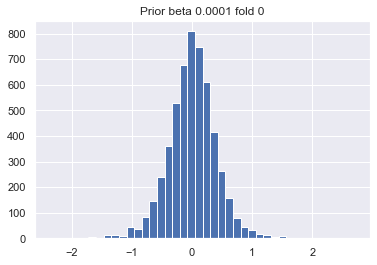

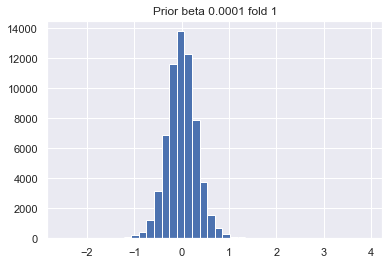

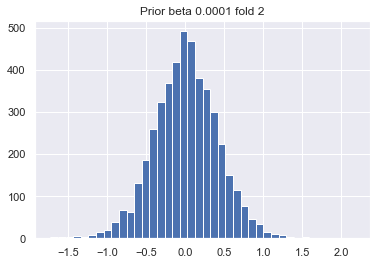

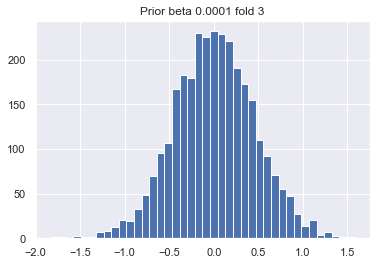

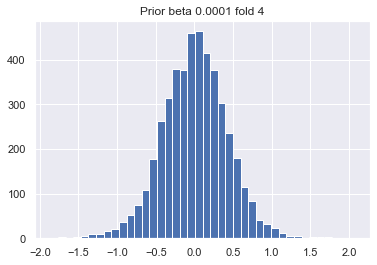

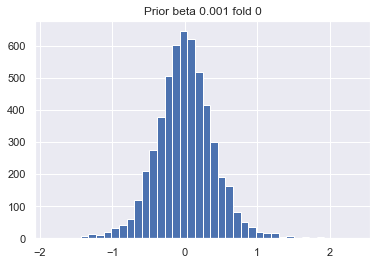

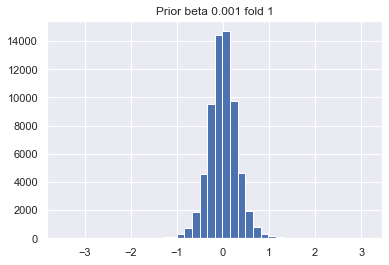

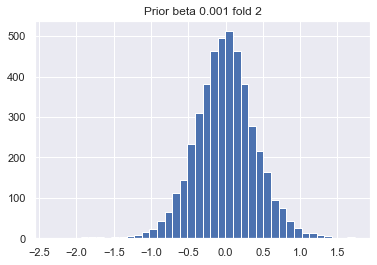

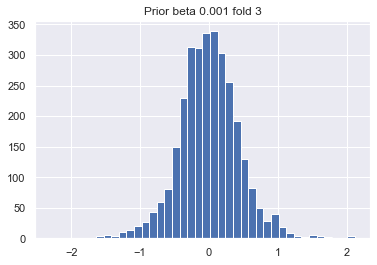

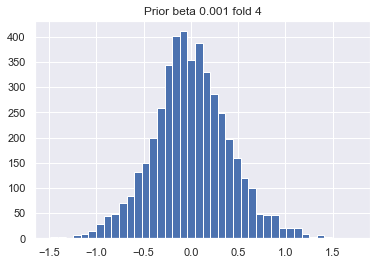

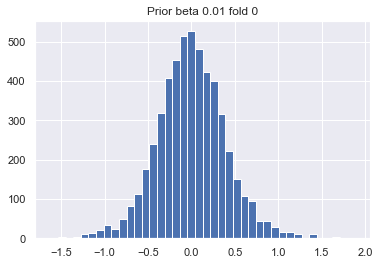

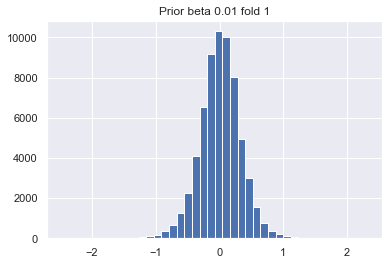

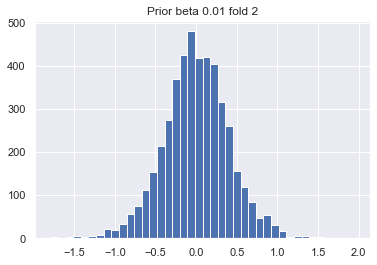

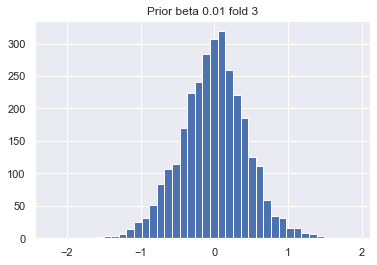

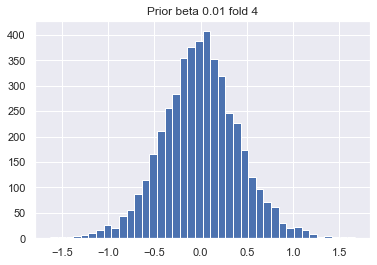

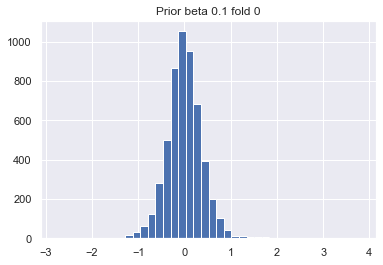

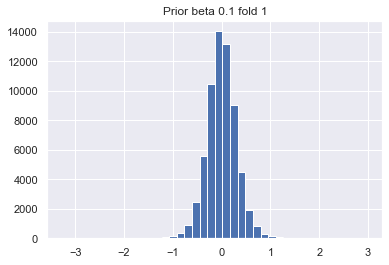

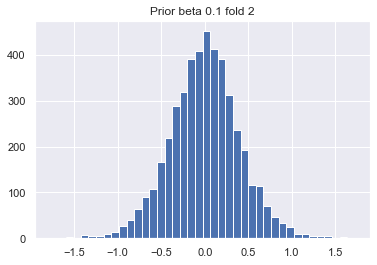

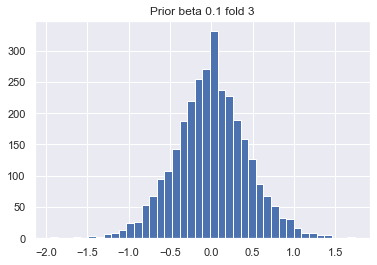

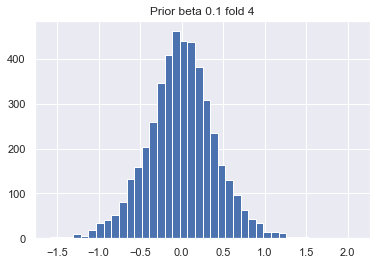

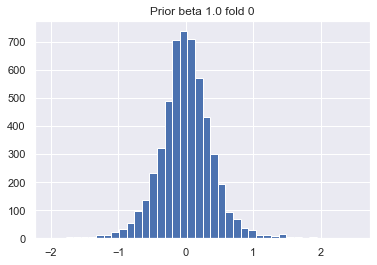

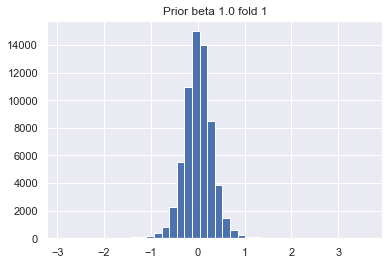

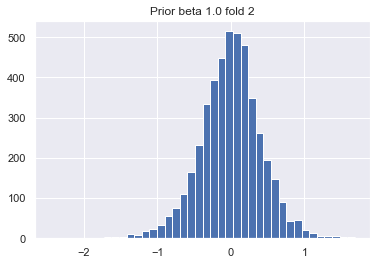

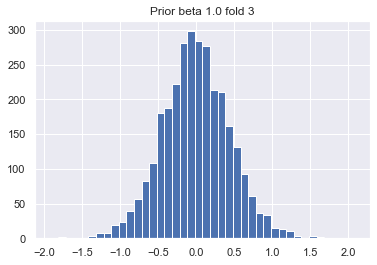

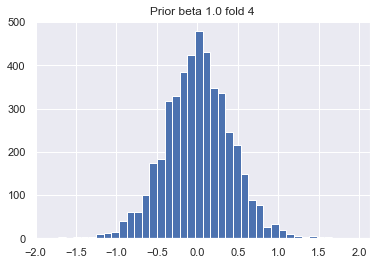

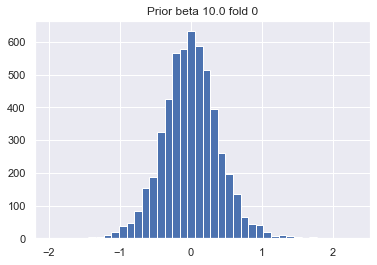

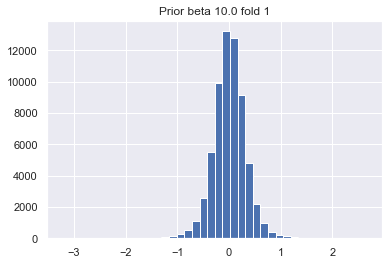

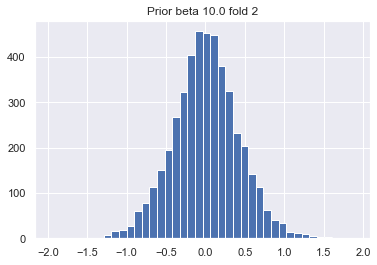

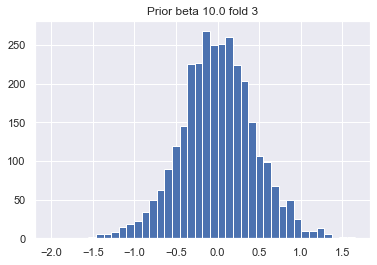

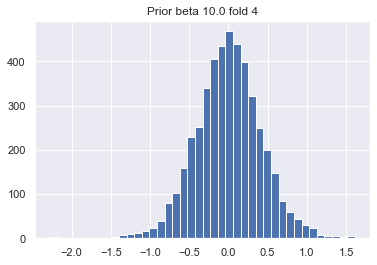

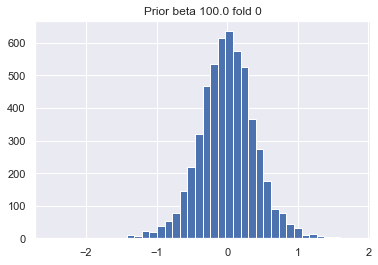

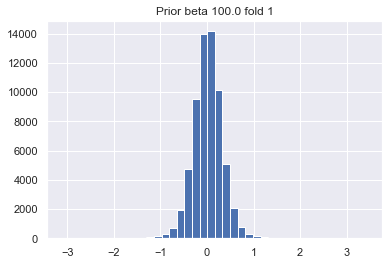

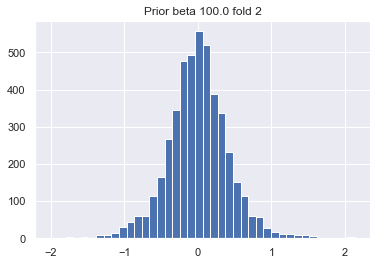

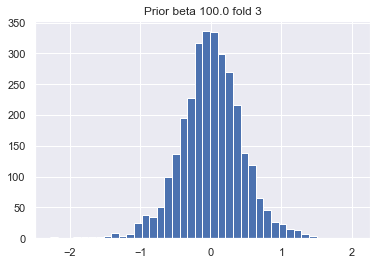

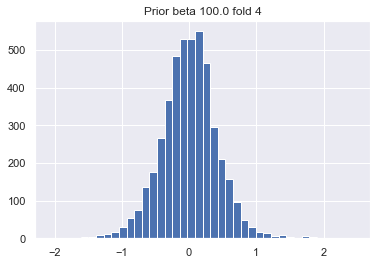

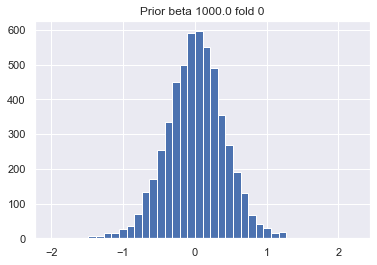

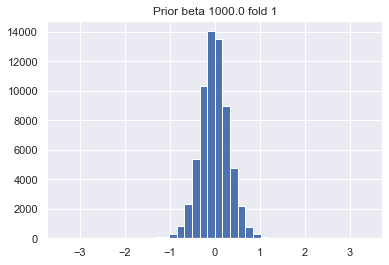

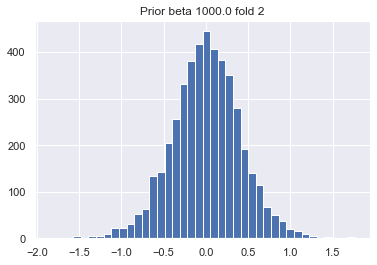

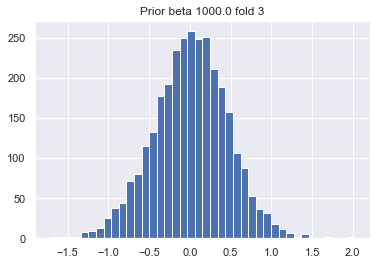

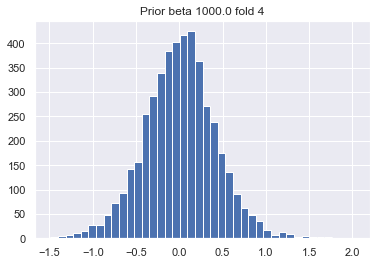

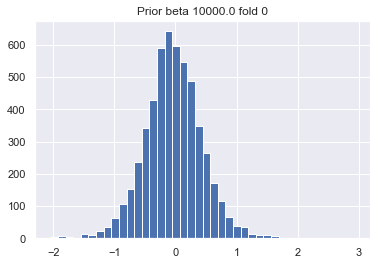

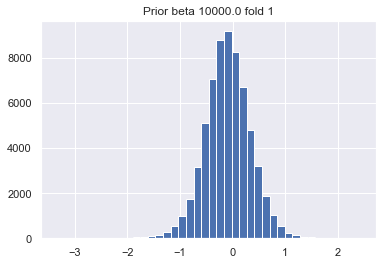

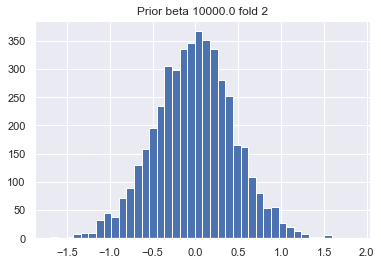

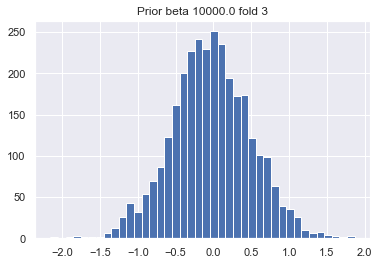

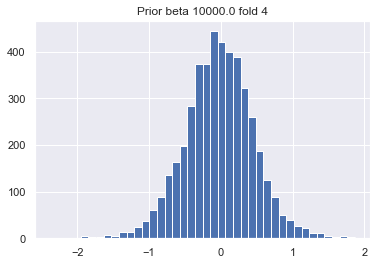

In [13]:
df_result_all = pd.DataFrame({})
cell = "U2OS"
j = 3
for prior_beta in prior_betas:
    genes_1 = np.load('../results/SameCellimputationModel/genes_subsets/genes_1'+cell+'_iter'+str(j)+'.npy',allow_pickle=True)
    genes_2 = np.setdiff1d(cmap.columns.values,genes_1)
    num_genes = genes_1.shape[0]
    valPear = []
    valPear_1 = []
    valPear_2 = []
    for i in range(model_params['no_folds']):
        trainInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/train_'+str(i)+'.csv',index_col=0)
        valInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/val_'+str(i)+'.csv',index_col=0)
            
        if len(trainInfo)<950:
            bs = 256
        else:
            bs = model_params['batch_size']
            
        cmap_train = cmap.loc[trainInfo.sig_id,:]
        cols = cmap_train.columns.values
        cmap_train_shuffled = cmap_train.sample(frac=1, axis=1)
        cmap_train_shuffled.columns = cols
        cmap_val = cmap.loc[valInfo.sig_id,:]
        N = len(cmap_train)
        
        curState_1 = torch.rand((N, model_params['latent_dim']), dtype=torch.float, requires_grad=False).to(device)
        curState_2 = torch.rand((N, model_params['latent_dim']), dtype=torch.float, requires_grad=False).to(device)
        # Network
        decoder_1 = Decoder(model_params['latent_dim'],model_params['decoder_1_hiddens'],num_genes,
                                dropRate=model_params['dropout_decoder'], 
                                activation=model_params['decoder_activation']).to(device)
        decoder_2 = Decoder(model_params['latent_dim'],model_params['decoder_2_hiddens'],num_genes,
                                dropRate=model_params['dropout_decoder'], 
                                activation=model_params['decoder_activation']).to(device)
        encoder_1 = SimpleEncoder(num_genes,model_params['encoder_1_hiddens'],model_params['latent_dim'],
                                      dropRate=model_params['dropout_encoder'], 
                                      activation=model_params['encoder_activation'],
                                     normalizeOutput=False).to(device)
        encoder_2 = SimpleEncoder(num_genes,model_params['encoder_2_hiddens'],model_params['latent_dim'],
                                          dropRate=model_params['dropout_encoder'], 
                                          activation=model_params['encoder_activation'],
                                     normalizeOutput=False).to(device)
        prior_d = PriorDiscriminator(model_params['latent_dim']).to(device)
        local_d = LocalDiscriminator(model_params['latent_dim'],model_params['latent_dim']).to(device)

        allParams = list(decoder_1.parameters()) + list(encoder_1.parameters())
        allParams = allParams + list(decoder_2.parameters()) + list(encoder_2.parameters())
        allParams = allParams  + list(local_d.parameters())
        allParams = allParams + list(prior_d.parameters())
        optimizer = torch.optim.Adam(allParams, lr=model_params['encoding_lr'])
        #optimizeD = torch.optim.Adam(prior_d.parameters(), lr=model_params['encoding_lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                        step_size=model_params['schedule_step_enc'],
                                                        gamma=model_params['gamma_enc'])
        trainLoss = []
        trainLossSTD = []
        for e in range(NUM_EPOCHS):
            encoder_1.train()
            decoder_1.train()
            encoder_2.train()
            decoder_2.train()
            prior_d.train()
            local_d.train()

            trainloader = getSamples(N, bs)
            trainLoss_ALL = []
            for dataIndex in trainloader:

                data_1 = torch.tensor(cmap_train.loc[:,genes_1].values).float()
                data_1 = data_1[dataIndex,:].to(device)
                data_2 = torch.tensor(cmap_train.loc[:,genes_2].values).float()
                data_2 = data_2[dataIndex,:].to(device)
                    
                conditions = trainInfo.conditionId.values[dataIndex]
                conditions = np.concatenate((conditions,conditions))
                size = conditions.size
                conditions = conditions.reshape(size,1)
                conditions = conditions == conditions.transpose()
                conditions = conditions*1
                mask = torch.tensor(conditions).to(device).detach()
                pos_mask = mask
                neg_mask = 1 - mask
                log_2 = math.log(2.)
                
                optimizer.zero_grad()
                #optimizeD.zero_grad()
                
                z_1 = encoder_1(data_1)
                z_2 = encoder_2(data_2)
                    
                #print('Epoch %s'%e)
                #print(z_1)
                    
                latent_vectors = torch.cat((z_1, z_2), 0)
                z_un = local_d(latent_vectors)
                #z_un_1 = local_d(z_1)
                #z_un_2 = local_d(z_2)
                #res_un = torch.matmul(z_un_1, z_un_2.t())
                res_un = torch.matmul(z_un, z_un.t())
                    
                #print(res_un)
                    
                Xhat_1 = decoder_1(z_1)
                Xhat_2 = decoder_2(z_2)
                loss_1 = torch.mean(torch.sum((Xhat_1 - data_1)**2,dim=1)) + encoder_1.L2Regularization(model_params['enc_l2_reg']) + decoder_1.L2Regularization(model_params['dec_l2_reg'])
                loss_2 = torch.mean(torch.sum((Xhat_2 - data_2)**2,dim=1)) +encoder_2.L2Regularization(model_params['enc_l2_reg']) + decoder_2.L2Regularization(model_params['dec_l2_reg'])
                    
                silimalityLoss = torch.sum(torch.cdist(latent_vectors, latent_vectors) * pos_mask.float()) / pos_mask.float().sum()
                #silimalityLoss = torch.mean(torch.cdist(z_1, z_2))
                w1 = latent_vectors.norm(p=2, dim=1, keepdim=True)
                w2 = latent_vectors.norm(p=2, dim=1, keepdim=True)
                cosineLoss = torch.mm(latent_vectors, latent_vectors.t()) / (w1 * w2.t()).clamp(min=1e-6)
                cosineLoss = torch.sum(cosineLoss * pos_mask.float()) / pos_mask.float().sum()
                #cosineLoss = torch.mean(cosineLoss)

                p_samples = res_un * pos_mask.float()
                q_samples = res_un * neg_mask.float()

                Ep = log_2 - F.softplus(- p_samples)
                Eq = F.softplus(-q_samples) + q_samples - log_2

                Ep = (Ep * pos_mask.float()).sum() / pos_mask.float().sum()
                Eq = (Eq * neg_mask.float()).sum() / neg_mask.float().sum()
                mi_loss = Eq - Ep
                #mi_loss = torch.nan_to_num(mi_loss, nan=1e-03)

                prior = torch.rand_like(torch.cat((z_1, z_2), 0))
                #prior = torch.randn(torch.cat((z_1, z_2), 0).shape).to(device)
                term_a = torch.log(prior_d(prior)).mean()
                term_b = torch.log(1.0 - prior_d(torch.cat((z_1, z_2), 0))).mean()
                #term_b = torch.log(prior_d(torch.cat((z_1, z_2), 0)) + 1e-06).mean()
                prior_loss = -(term_a + term_b)* prior_beta
                ### MSE-LIKE PRIOR
                #prior_loss1 = prior_beta * uniformLoss(curState_1, dataIndex, z_1,maxConstraintFactor=1)
                #prior_loss2 = prior_beta * uniformLoss(curState_2, dataIndex, z_2,maxConstraintFactor=1)
                #prior_loss_binned = torch.mean(torch.sum((torch.cat((z_1, z_2), 0) - prior)**2,dim=1))
                #prior_loss = 0.5*(prior_loss1+prior_loss2) + prior_loss_binned
                ### KL-divergence prior
                #mu1 = torch.mean(torch.cat((z_1, z_2), 0),0)
                ##mu2 = torch.mean(prior,0)
                #sd1 = torch.std(torch.cat((z_1, z_2), 0),0)
                ##sd2 = torch.std(prior,0)
                #prior_loss = prior_beta * kl_loss(mu1,sd1)
                    
                loss = loss_1 + loss_2 + model_params[
                        'similarity_reg']*silimalityLoss - model_params[
                        'cosine_loss'] * cosineLoss + prior_loss + model_params['lambda_mi_loss'] * mi_loss
                loss.backward()
                #prior_loss.backward(retain_graph=True)
                optimizer.step()
                #optimizeD.step()

                pear_1 = pearson_r(Xhat_1.detach(), data_1.detach())
                mse_1 = torch.mean(torch.mean((Xhat_1.detach() - data_1.detach()) ** 2, dim=1))
                pear_2 = pearson_r(Xhat_2.detach(), data_2.detach())
                mse_2 = torch.mean(torch.mean((Xhat_2.detach() - data_2.detach()) ** 2, dim=1))
                trainLoss_ALL.append(loss.item())
                    
            if e%250==0:
                outString = 'Cell-line : '+cell+', prior beta {:.2f}'.format(prior_beta)
                outString += ', Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(i + 1, e + 1, NUM_EPOCHS)
                outString += ', pearson_1={:.4f}'.format(pear_1.item())
                outString += ', MSE_1={:.4f}'.format(mse_1.item())
                outString += ', pearson_2={:.4f}'.format(pear_2.item())
                outString += ', MSE_2={:.4f}'.format(mse_2.item())
                outString += ', MI Loss={:.4f}'.format(mi_loss.item())
                outString += ', Prior Loss={:.4f}'.format(prior_loss.item())
                #outString += ', Prior Loss 2={:.4f}'.format(prior_gen.item())
                outString += ', Cosine ={:.4f}'.format(cosineLoss.item())
                outString += ', silimalityLoss ={:.4f}'.format(silimalityLoss.item())
                outString += ', loss={:.4f}'.format(loss.item())
                print(outString)
            scheduler.step()
            trainLoss.append(np.mean(trainLoss_ALL))
            trainLossSTD.append(np.std(trainLoss_ALL))
        outString = 'Cell-line : '+cell+', prior beta {:.2f}'.format(prior_beta)
        outString += ', Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(i + 1, e + 1, NUM_EPOCHS)
        outString += ', pearson_1={:.4f}'.format(pear_1.item())
        outString += ', MSE_1={:.4f}'.format(mse_1.item())
        outString += ', pearson_2={:.4f}'.format(pear_2.item())
        outString += ', MSE_2={:.4f}'.format(mse_2.item())
        outString += ', MI Loss={:.4f}'.format(mi_loss.item())
        outString += ', Prior Loss={:.4f}'.format(prior_loss.item())
        #outString += ', Prior Loss 2={:.4f}'.format(prior_gen.item())
        outString += ', Cosine ={:.4f}'.format(cosineLoss.item())
        outString += ', silimalityLoss ={:.4f}'.format(silimalityLoss.item())
        outString += ', loss={:.4f}'.format(loss.item())
        print(outString)
        plt.figure()
        plt.hist(torch.cat((z_1, z_2), 0).detach().flatten().cpu().numpy(),40)
        plt.title('Prior beta %s fold %s'%(prior_beta,i))

        encoder_1.eval()
        decoder_1.eval()
        encoder_2.eval()
        decoder_2.eval()
        prior_d.eval()
        local_d.eval()
            
        print('Validation performance for cell %s for beta %s for split %s'%(cell,prior_beta,i+1))


        X_1 = torch.tensor(cmap_val.loc[:,genes_1].values).float().to(device)
        X_2 = torch.tensor(cmap_val.loc[:,genes_2].values).float().to(device)
                    
        z_1 = encoder_1(X_1)
        z_2 = encoder_2(X_2)
        Xhat_1 = decoder_1(z_1)
        Xhat_2 = decoder_2(z_2)
            
        pear_1 = pearson_r(Xhat_1.detach(), X_1.detach())
        pear_2 = pearson_r(Xhat_2.detach(), X_2.detach())
        valPear_1.append(pear_1.item())
        valPear_2.append(pear_2.item())

        print('Pearson correlation 1: %s'%pear_1.item())
        print('Pearson correlation 2: %s'%pear_2.item())
    
    
        x_hat_2_equivalent = decoder_2(z_1).detach()
        pearson_2 = pearson_r(x_hat_2_equivalent.detach(), X_2.detach())
        print('Pearson correlation 1 to 2: %s'%pearson_2.item())
        x_hat_1_equivalent = decoder_1(z_2).detach()
        pearson_1 = pearson_r(x_hat_1_equivalent.detach(), X_1.detach())
        print('Pearson correlation 2 to 1: %s'%pearson_1.item())
        
        valPear.append([pearson_2.item(),pearson_1.item()])
            
        torch.save(decoder_1,'../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_current/decoder_1_fold%s_beta%s.pt'%(i,prior_beta))
        torch.save(decoder_2,'../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_current/decoder_2_fold%s_beta%s.pt'%(i,prior_beta))
        torch.save(prior_d,'../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_current/priorDiscr_fold%s_beta%s.pt'%(i,prior_beta))
        torch.save(local_d,'../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_current/localDiscr_fold%s_beta%s.pt'%(i,prior_beta))
        torch.save(encoder_1,'../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_current/encoder_1_fold%s_beta%s.pt'%(i,prior_beta))
        torch.save(encoder_2,'../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_current/encoder_2_fold%s_beta%s.pt'%(i,prior_beta))
        
    valPear = np.array(valPear)
    df_result = pd.DataFrame({'model_pearson2to1':valPear[:,0],'model_pearson1to2':valPear[:,1],
                              'recon_pear_2':valPear_2 ,'recon_pear_1':valPear_1})
    df_result['model'] = 'model'
    df_result['set'] = 'validation'
    df_result['cell'] = cell
    df_result['beta'] = prior_beta
    df_result_all = df_result_all.append(df_result)
    df_result_all.to_csv('../results/PriorLossAnalysis/translation_results_testytest_'+cell+'.csv')

# Embeed for uniform prior : uniformLoss, discriminator, KLD for beta =1 and 100, 10**4

In [14]:
cell = "U2OS"
j = 3
genes_1 = np.load('../results/SameCellimputationModel/genes_subsets/genes_1'+cell+'_iter'+str(j)+'.npy',allow_pickle=True)
genes_2 = np.setdiff1d(cmap.columns.values,genes_1)

### First uniformLoss

In [18]:
betas = [1.,100.,10000.]
for prior_beta in betas:
    print('Start beta: %s'%prior_beta)
    for i in range(model_params['no_folds']):
        
        trainInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/train_'+str(i)+'.csv',index_col=0)
        valInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/val_'+str(i)+'.csv',index_col=0)
        cmap_train = cmap.loc[trainInfo.sig_id,:]
        cols = cmap_train.columns.values
        cmap_val = cmap.loc[valInfo.sig_id,:]
        
        Xtrain_1 = torch.tensor(cmap_train.loc[:,genes_1].values).float().to(device)
        Xtrain_2 = torch.tensor(cmap_train.loc[:,genes_2].values).float().to(device)
        Xval_1 = torch.tensor(cmap_val.loc[:,genes_1].values).float().to(device)
        Xval_2 = torch.tensor(cmap_val.loc[:,genes_2].values).float().to(device)
        
        encoder_1 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_uniform_mselike/encoder_1_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_2 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_uniform_mselike/encoder_2_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_1.eval()
        encoder_2.eval()
        
        ztrain_1 = encoder_1(Xtrain_1)
        ztrain_2 = encoder_2(Xtrain_2)
        zval_1 = encoder_1(Xval_1)
        zval_2 = encoder_2(Xval_2)
        
        ## Save train embeddings 
        df_train_1 = pd.DataFrame(ztrain_1.detach().cpu().numpy())
        df_train_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_1.index = trainInfo.sig_id
        df_train_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_uniform_mselike/train_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_train_2 = pd.DataFrame(ztrain_2.detach().cpu().numpy())
        df_train_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_2.index = trainInfo.sig_id
        df_train_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_uniform_mselike/train_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        
        ## Save validation embeddings 
        df_val_1 = pd.DataFrame(zval_1.detach().cpu().numpy())
        df_val_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_1.index = valInfo.sig_id
        df_val_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_uniform_mselike/val_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_val_2 = pd.DataFrame(zval_2.detach().cpu().numpy())
        df_val_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_2.index = valInfo.sig_id
        df_val_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_uniform_mselike/val_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        #print('Finished fold %s'%i)

Start beta: 1.0
Finished fold 0
Finished fold 1
Finished fold 2
Finished fold 3
Finished fold 4
Start beta: 100.0
Finished fold 0
Finished fold 1
Finished fold 2
Finished fold 3
Finished fold 4
Start beta: 10000.0
Finished fold 0
Finished fold 1
Finished fold 2
Finished fold 3
Finished fold 4


### Secondly uniform discriminator

In [19]:
betas = [1.,100.,10000.]
for prior_beta in betas:
    print('Start beta: %s'%prior_beta)
    for i in range(model_params['no_folds']):
        
        trainInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/train_'+str(i)+'.csv',index_col=0)
        valInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/val_'+str(i)+'.csv',index_col=0)
        cmap_train = cmap.loc[trainInfo.sig_id,:]
        cols = cmap_train.columns.values
        cmap_val = cmap.loc[valInfo.sig_id,:]
        
        Xtrain_1 = torch.tensor(cmap_train.loc[:,genes_1].values).float().to(device)
        Xtrain_2 = torch.tensor(cmap_train.loc[:,genes_2].values).float().to(device)
        Xval_1 = torch.tensor(cmap_val.loc[:,genes_1].values).float().to(device)
        Xval_2 = torch.tensor(cmap_val.loc[:,genes_2].values).float().to(device)
        
        encoder_1 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_discr_uniform/encoder_1_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_2 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_discr_uniform/encoder_2_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_1.eval()
        encoder_2.eval()
        
        ztrain_1 = encoder_1(Xtrain_1)
        ztrain_2 = encoder_2(Xtrain_2)
        zval_1 = encoder_1(Xval_1)
        zval_2 = encoder_2(Xval_2)
        
        ## Save train embeddings 
        df_train_1 = pd.DataFrame(ztrain_1.detach().cpu().numpy())
        df_train_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_1.index = trainInfo.sig_id
        df_train_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_discr_uniform/train_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_train_2 = pd.DataFrame(ztrain_2.detach().cpu().numpy())
        df_train_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_2.index = trainInfo.sig_id
        df_train_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_discr_uniform/train_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        
        ## Save validation embeddings 
        df_val_1 = pd.DataFrame(zval_1.detach().cpu().numpy())
        df_val_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_1.index = valInfo.sig_id
        df_val_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_discr_uniform/val_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_val_2 = pd.DataFrame(zval_2.detach().cpu().numpy())
        df_val_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_2.index = valInfo.sig_id
        df_val_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_discr_uniform/val_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        #print('Finished fold %s'%i)

Start beta: 1.0
Finished fold 0
Finished fold 1
Finished fold 2
Finished fold 3
Finished fold 4
Start beta: 100.0
Finished fold 0
Finished fold 1
Finished fold 2
Finished fold 3
Finished fold 4
Start beta: 10000.0
Finished fold 0
Finished fold 1
Finished fold 2
Finished fold 3
Finished fold 4


### Thirdly current discriminator

In [21]:
betas = [1.,100.,10000.]
for prior_beta in betas:
    print('Start beta: %s'%prior_beta)
    for i in range(model_params['no_folds']):
        
        trainInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/train_'+str(i)+'.csv',index_col=0)
        valInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/val_'+str(i)+'.csv',index_col=0)
        cmap_train = cmap.loc[trainInfo.sig_id,:]
        cols = cmap_train.columns.values
        cmap_val = cmap.loc[valInfo.sig_id,:]
        
        Xtrain_1 = torch.tensor(cmap_train.loc[:,genes_1].values).float().to(device)
        Xtrain_2 = torch.tensor(cmap_train.loc[:,genes_2].values).float().to(device)
        Xval_1 = torch.tensor(cmap_val.loc[:,genes_1].values).float().to(device)
        Xval_2 = torch.tensor(cmap_val.loc[:,genes_2].values).float().to(device)
        
        encoder_1 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_current/encoder_1_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_2 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_current/encoder_2_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_1.eval()
        encoder_2.eval()
        
        ztrain_1 = encoder_1(Xtrain_1)
        ztrain_2 = encoder_2(Xtrain_2)
        zval_1 = encoder_1(Xval_1)
        zval_2 = encoder_2(Xval_2)
        
        ## Save train embeddings 
        df_train_1 = pd.DataFrame(ztrain_1.detach().cpu().numpy())
        df_train_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_1.index = trainInfo.sig_id
        df_train_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_current/train_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_train_2 = pd.DataFrame(ztrain_2.detach().cpu().numpy())
        df_train_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_2.index = trainInfo.sig_id
        df_train_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_current/train_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        
        ## Save validation embeddings 
        df_val_1 = pd.DataFrame(zval_1.detach().cpu().numpy())
        df_val_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_1.index = valInfo.sig_id
        df_val_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_current/val_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_val_2 = pd.DataFrame(zval_2.detach().cpu().numpy())
        df_val_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_2.index = valInfo.sig_id
        df_val_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_current/val_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        #print('Finished fold %s'%i)

Start beta: 1.0
Start beta: 100.0
Start beta: 10000.0


### Normal KLD

In [22]:
betas = [1.,100.,10000.]
for prior_beta in betas:
    print('Start beta: %s'%prior_beta)
    for i in range(model_params['no_folds']):
        
        trainInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/train_'+str(i)+'.csv',index_col=0)
        valInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/val_'+str(i)+'.csv',index_col=0)
        cmap_train = cmap.loc[trainInfo.sig_id,:]
        cols = cmap_train.columns.values
        cmap_val = cmap.loc[valInfo.sig_id,:]
        
        Xtrain_1 = torch.tensor(cmap_train.loc[:,genes_1].values).float().to(device)
        Xtrain_2 = torch.tensor(cmap_train.loc[:,genes_2].values).float().to(device)
        Xval_1 = torch.tensor(cmap_val.loc[:,genes_1].values).float().to(device)
        Xval_2 = torch.tensor(cmap_val.loc[:,genes_2].values).float().to(device)
        
        encoder_1 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_KLD_normal/encoder_1_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_2 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_KLD_normal/encoder_2_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_1.eval()
        encoder_2.eval()
        
        ztrain_1 = encoder_1(Xtrain_1)
        ztrain_2 = encoder_2(Xtrain_2)
        zval_1 = encoder_1(Xval_1)
        zval_2 = encoder_2(Xval_2)
        
        ## Save train embeddings 
        df_train_1 = pd.DataFrame(ztrain_1.detach().cpu().numpy())
        df_train_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_1.index = trainInfo.sig_id
        df_train_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_KLD_normal/train_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_train_2 = pd.DataFrame(ztrain_2.detach().cpu().numpy())
        df_train_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_2.index = trainInfo.sig_id
        df_train_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_KLD_normal/train_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        
        ## Save validation embeddings 
        df_val_1 = pd.DataFrame(zval_1.detach().cpu().numpy())
        df_val_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_1.index = valInfo.sig_id
        df_val_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_KLD_normal/val_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_val_2 = pd.DataFrame(zval_2.detach().cpu().numpy())
        df_val_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_2.index = valInfo.sig_id
        df_val_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_KLD_normal/val_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        #print('Finished fold %s'%i)

Start beta: 1.0
Start beta: 100.0
Start beta: 10000.0


### Normal discriminator

In [23]:
betas = [1.,100.,10000.]
for prior_beta in betas:
    print('Start beta: %s'%prior_beta)
    for i in range(model_params['no_folds']):
        
        trainInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/train_'+str(i)+'.csv',index_col=0)
        valInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/val_'+str(i)+'.csv',index_col=0)
        cmap_train = cmap.loc[trainInfo.sig_id,:]
        cols = cmap_train.columns.values
        cmap_val = cmap.loc[valInfo.sig_id,:]
        
        Xtrain_1 = torch.tensor(cmap_train.loc[:,genes_1].values).float().to(device)
        Xtrain_2 = torch.tensor(cmap_train.loc[:,genes_2].values).float().to(device)
        Xval_1 = torch.tensor(cmap_val.loc[:,genes_1].values).float().to(device)
        Xval_2 = torch.tensor(cmap_val.loc[:,genes_2].values).float().to(device)
        
        encoder_1 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_discr_normal/encoder_1_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_2 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_discr_normal/encoder_2_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_1.eval()
        encoder_2.eval()
        
        ztrain_1 = encoder_1(Xtrain_1)
        ztrain_2 = encoder_2(Xtrain_2)
        zval_1 = encoder_1(Xval_1)
        zval_2 = encoder_2(Xval_2)
        
        ## Save train embeddings 
        df_train_1 = pd.DataFrame(ztrain_1.detach().cpu().numpy())
        df_train_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_1.index = trainInfo.sig_id
        df_train_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_discr_normal/train_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_train_2 = pd.DataFrame(ztrain_2.detach().cpu().numpy())
        df_train_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_2.index = trainInfo.sig_id
        df_train_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_discr_normal/train_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        
        ## Save validation embeddings 
        df_val_1 = pd.DataFrame(zval_1.detach().cpu().numpy())
        df_val_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_1.index = valInfo.sig_id
        df_val_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_discr_normal/val_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_val_2 = pd.DataFrame(zval_2.detach().cpu().numpy())
        df_val_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_2.index = valInfo.sig_id
        df_val_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_discr_normal/val_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        #print('Finished fold %s'%i)

Start beta: 1.0
Start beta: 100.0
Start beta: 10000.0


### Normal normalLoss (mselike)

In [24]:
betas = [1.,100.,10000.]
for prior_beta in betas:
    print('Start beta: %s'%prior_beta)
    for i in range(model_params['no_folds']):
        
        trainInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/train_'+str(i)+'.csv',index_col=0)
        valInfo = pd.read_csv('../preprocessing/preprocessed_data/SameCellimputationModel/'+cell+'/val_'+str(i)+'.csv',index_col=0)
        cmap_train = cmap.loc[trainInfo.sig_id,:]
        cols = cmap_train.columns.values
        cmap_val = cmap.loc[valInfo.sig_id,:]
        
        Xtrain_1 = torch.tensor(cmap_train.loc[:,genes_1].values).float().to(device)
        Xtrain_2 = torch.tensor(cmap_train.loc[:,genes_2].values).float().to(device)
        Xval_1 = torch.tensor(cmap_val.loc[:,genes_1].values).float().to(device)
        Xval_2 = torch.tensor(cmap_val.loc[:,genes_2].values).float().to(device)
        
        encoder_1 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_normal_mselike/encoder_1_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_2 = torch.load('../results/PriorLossAnalysis/models_AutoTransOp/'+cell+'_normal_mselike/encoder_2_fold%s_beta%s.pt'%(i,prior_beta))
        encoder_1.eval()
        encoder_2.eval()
        
        ztrain_1 = encoder_1(Xtrain_1)
        ztrain_2 = encoder_2(Xtrain_2)
        zval_1 = encoder_1(Xval_1)
        zval_2 = encoder_2(Xval_2)
        
        ## Save train embeddings 
        df_train_1 = pd.DataFrame(ztrain_1.detach().cpu().numpy())
        df_train_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_1.index = trainInfo.sig_id
        df_train_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_normal_mselike/train_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_train_2 = pd.DataFrame(ztrain_2.detach().cpu().numpy())
        df_train_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_train_2.index = trainInfo.sig_id
        df_train_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_normal_mselike/train_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        
        ## Save validation embeddings 
        df_val_1 = pd.DataFrame(zval_1.detach().cpu().numpy())
        df_val_1.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_1.index = valInfo.sig_id
        df_val_1.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_normal_mselike/val_embs1_fold%s_beta%s.csv'%(i,prior_beta))
        df_val_2 = pd.DataFrame(zval_2.detach().cpu().numpy())
        df_val_2.columns = ['z_'+str(n) for n in range(model_params['latent_dim'])]
        df_val_2.index = valInfo.sig_id
        df_val_2.to_csv('../results/PriorLossAnalysis/embs_AutoTransOp/'+cell+'_normal_mselike/val_embs2_fold%s_beta%s.csv'%(i,prior_beta))
        #print('Finished fold %s'%i)

Start beta: 1.0
Start beta: 100.0
Start beta: 10000.0
